## Install the package dependencies before running this notebook

In [870]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy as np
import pickle
from glob import glob
import seaborn as sns
import pandas as pd
from torch import nn, optim

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [803]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

## Linear Model

In [776]:
'''
(50,2),(x,110,2)

Architecture:
1. We start with our original input
    1.1. Add 2 of the closest other inputs and outputs to current path? This would make tensor
    shape different for every input because inputs[0,0] is original shaped (50,2) while 
    inputs[0,1] is shaped (2,110,2)
2. Get a polynomial that describes direction
    2.1. 
3. Get a polynomial that describes speed
    3.1. 
    
Model:
- Needs to extract a list of 60 speeds (differences in (x,y) coordinates) from one output to 
the next
- Needs to extract a list of 60 directions (where the next (x,y) coordinate is headed) from
one output to the next

Architecture:
1. Speeds of 60 points, 60,2 4,2 = bias + x1+x2+x3
2. direction of 60 points, 60,2, 4,2 = bias + x1+x2+x3
input=(50,2) -> LSTM((50,2),16) -> Linear(16,16) -> LSTM(16,(60,2))

''';

In [1203]:
class LinearPred(nn.Module):

    def __init__(self):
        super().__init__()
        self.lin = nn.Sequential(
            nn.Linear(100, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.lin(x)
        x = x.reshape(-1, 60, 2)
        return x

In [1204]:
pred = LinearPred()
opt = optim.Adam(pred.parameters(), lr=3e-4)

# intialize a dataset
city = 'dearborn' 
split = 'train'
train_dataset = ArgoverseDataset(city = city, split = split)

batch_sz = 50  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

In [1205]:
for epoch in range(1000):
    total_loss = 0
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch
        preds = pred(inp)
        loss = ((preds - out) ** 2).sum()

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()
        
    print('epoch {} loss: {}'.format(epoch, total_loss / len(train_dataset)))

epoch 0 loss: 453456921.0834237
epoch 1 loss: 12265226.93319533
epoch 2 loss: 1564917.7979155725
epoch 3 loss: 295421.33000485913
epoch 4 loss: 203036.864478279
epoch 5 loss: 199057.68888024153
epoch 6 loss: 199367.30580742983
epoch 7 loss: 199632.04804361996
epoch 8 loss: 199966.746524863
epoch 9 loss: 200291.15260737014
epoch 10 loss: 200656.44047264484
epoch 11 loss: 200981.7545460459
epoch 12 loss: 201375.25625759337
epoch 13 loss: 201784.450655869
epoch 14 loss: 202303.5966146909
epoch 15 loss: 202647.15396517367
epoch 16 loss: 202895.37922390786
epoch 17 loss: 202928.2793130359
epoch 18 loss: 203193.8835085814
epoch 19 loss: 203108.6337158607
epoch 20 loss: 202901.03404852928
epoch 21 loss: 202729.95088427846
epoch 22 loss: 202629.65937567904
epoch 23 loss: 202116.72919640335
epoch 24 loss: 201233.4946183604
epoch 25 loss: 199813.02170785496
epoch 26 loss: 198170.86362061708
epoch 27 loss: 196305.91863739394
epoch 28 loss: 194388.3203015417
epoch 29 loss: 192466.6344197411
epoch 

KeyboardInterrupt: 

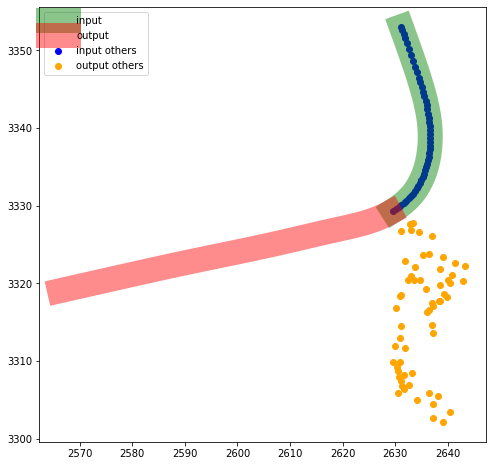

In [1235]:
point = 1477

inputs = []
outputs = []
inputs.append(train_dataset.inputs[point])
inputs.append(train_dataset.inputs[point])
outputs.append(train_dataset.outputs[point])
outputs.append(pred(torch.tensor(train_dataset.inputs[point])).detach().numpy().reshape(60,2))

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))

for i, (inp, out) in enumerate(zip(inputs, outputs)):
    if i==0:
        inpx = inp[:,0]
        inpy = inp[:,1]
        outx = out[:,0]
        outy = out[:,1]
        ax.plot(inpx, inpy, alpha=0.45, c='green', linewidth=25)
        ax.plot(outx, outy, alpha=0.45, c='red',  linewidth=25)
    else:
        inpx = inp[:,0]
        inpy = inp[:,1]
        outx = out[:,0]
        outy = out[:,1]
        ax.scatter(inpx, inpy, c='b')
        ax.scatter(outx, outy, c='orange')

ax.legend(['input','output','input others','output others'])

In [1206]:
val_dataset = ArgoverseDataset(city = city, split = 'val')
val_loader = DataLoader(val_dataset,batch_size=batch_sz)

val_loss = 0
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    preds = pred(inp)
    loss = ((preds - out) ** 2).sum()
    val_loss += loss.item()
    
    #show_sample_batch((inp, preds.detach()))
print('loss: {}'.format(np.sqrt(val_loss / len(val_dataset))))

loss: 141.60438429130252


In [1199]:
df_full = pd.DataFrame(columns=[f'v{i}' for i in range(120)])
for city in cities:
    test_dataset = ArgoverseDataset(city = city, split = 'test')
    test_loader = DataLoader(val_dataset,batch_size=500)
    outputs = torch.tensor([])
    
    inp = test_dataset.inputs
    inp = torch.tensor(inp)
    preds = pred(inp)
    outputs = torch.cat([outputs, preds])
    
    outputs = outputs.reshape(-1, 120).detach().numpy()
    df = pd.DataFrame(outputs)
    df.columns = [f'v{i}' for i in range(120)]
    df.index = [f'{i}_{city}' for i in range(len(outputs))]
    df_full = pd.concat([df_full, df])
df_full.index.name = 'ID'
df_full.to_csv('outputs1.csv')

## Convolutional Model

In [1087]:
class ConvPred(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 1, (1,2))
        )
        self.decoder = nn.Sequential(
            nn.Linear(50, 120)
        )
        
        
    def forward(self, x):
        x = self.encoder(x.float())
        x = x.reshape(-1, 50)
        x = self.decoder(x)
        x = x.reshape(60, 2)
        return x

In [1200]:
pred = ConvPred()
opt = optim.Adam(pred.parameters(), lr=1e-3)

# intialize a dataset
city = 'dearborn' 
split = 'train'
train_dataset = ArgoverseDataset(city = city, split = split)

batch_sz = 1  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

In [1201]:
for epoch in range(500):
    total_loss = 0
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch
        if inp.shape[0] != batch_sz:
            continue
        
        inp = torch.cat([inp, torch.tensor([train_dataset.inputs[closest_points[i_batch, 2]]])])
        preds = pred(inp)
        loss = ((preds - out) ** 2).sum()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_loss += loss.item()
        
    print('epoch {} loss: {}'.format(epoch, total_loss / len(train_dataset)))

KeyboardInterrupt: 

In [1091]:
val_dataset = ArgoverseDataset(city = city, split = 'val')
val_loader = DataLoader(val_dataset, batch_size=batch_sz)

val_loss = 0
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    inp = torch.cat([inp, torch.tensor([train_dataset.inputs[closest_points[i_batch, 2]]])])
    preds = pred(inp)
    loss = ((preds - out) ** 2).sum()
    val_loss += loss.item()
    
    #show_sample_batch((inp, preds.detach()))
print('loss: {}'.format(val_loss / len(val_dataset)))

loss: 2993304127.8108935


## Sample a batch of data and visualize 

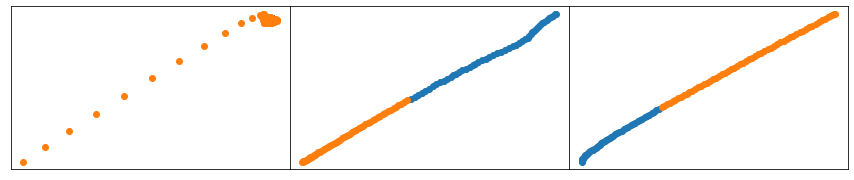

In [143]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

## EDA

### Heatmap per city per split (train/test)

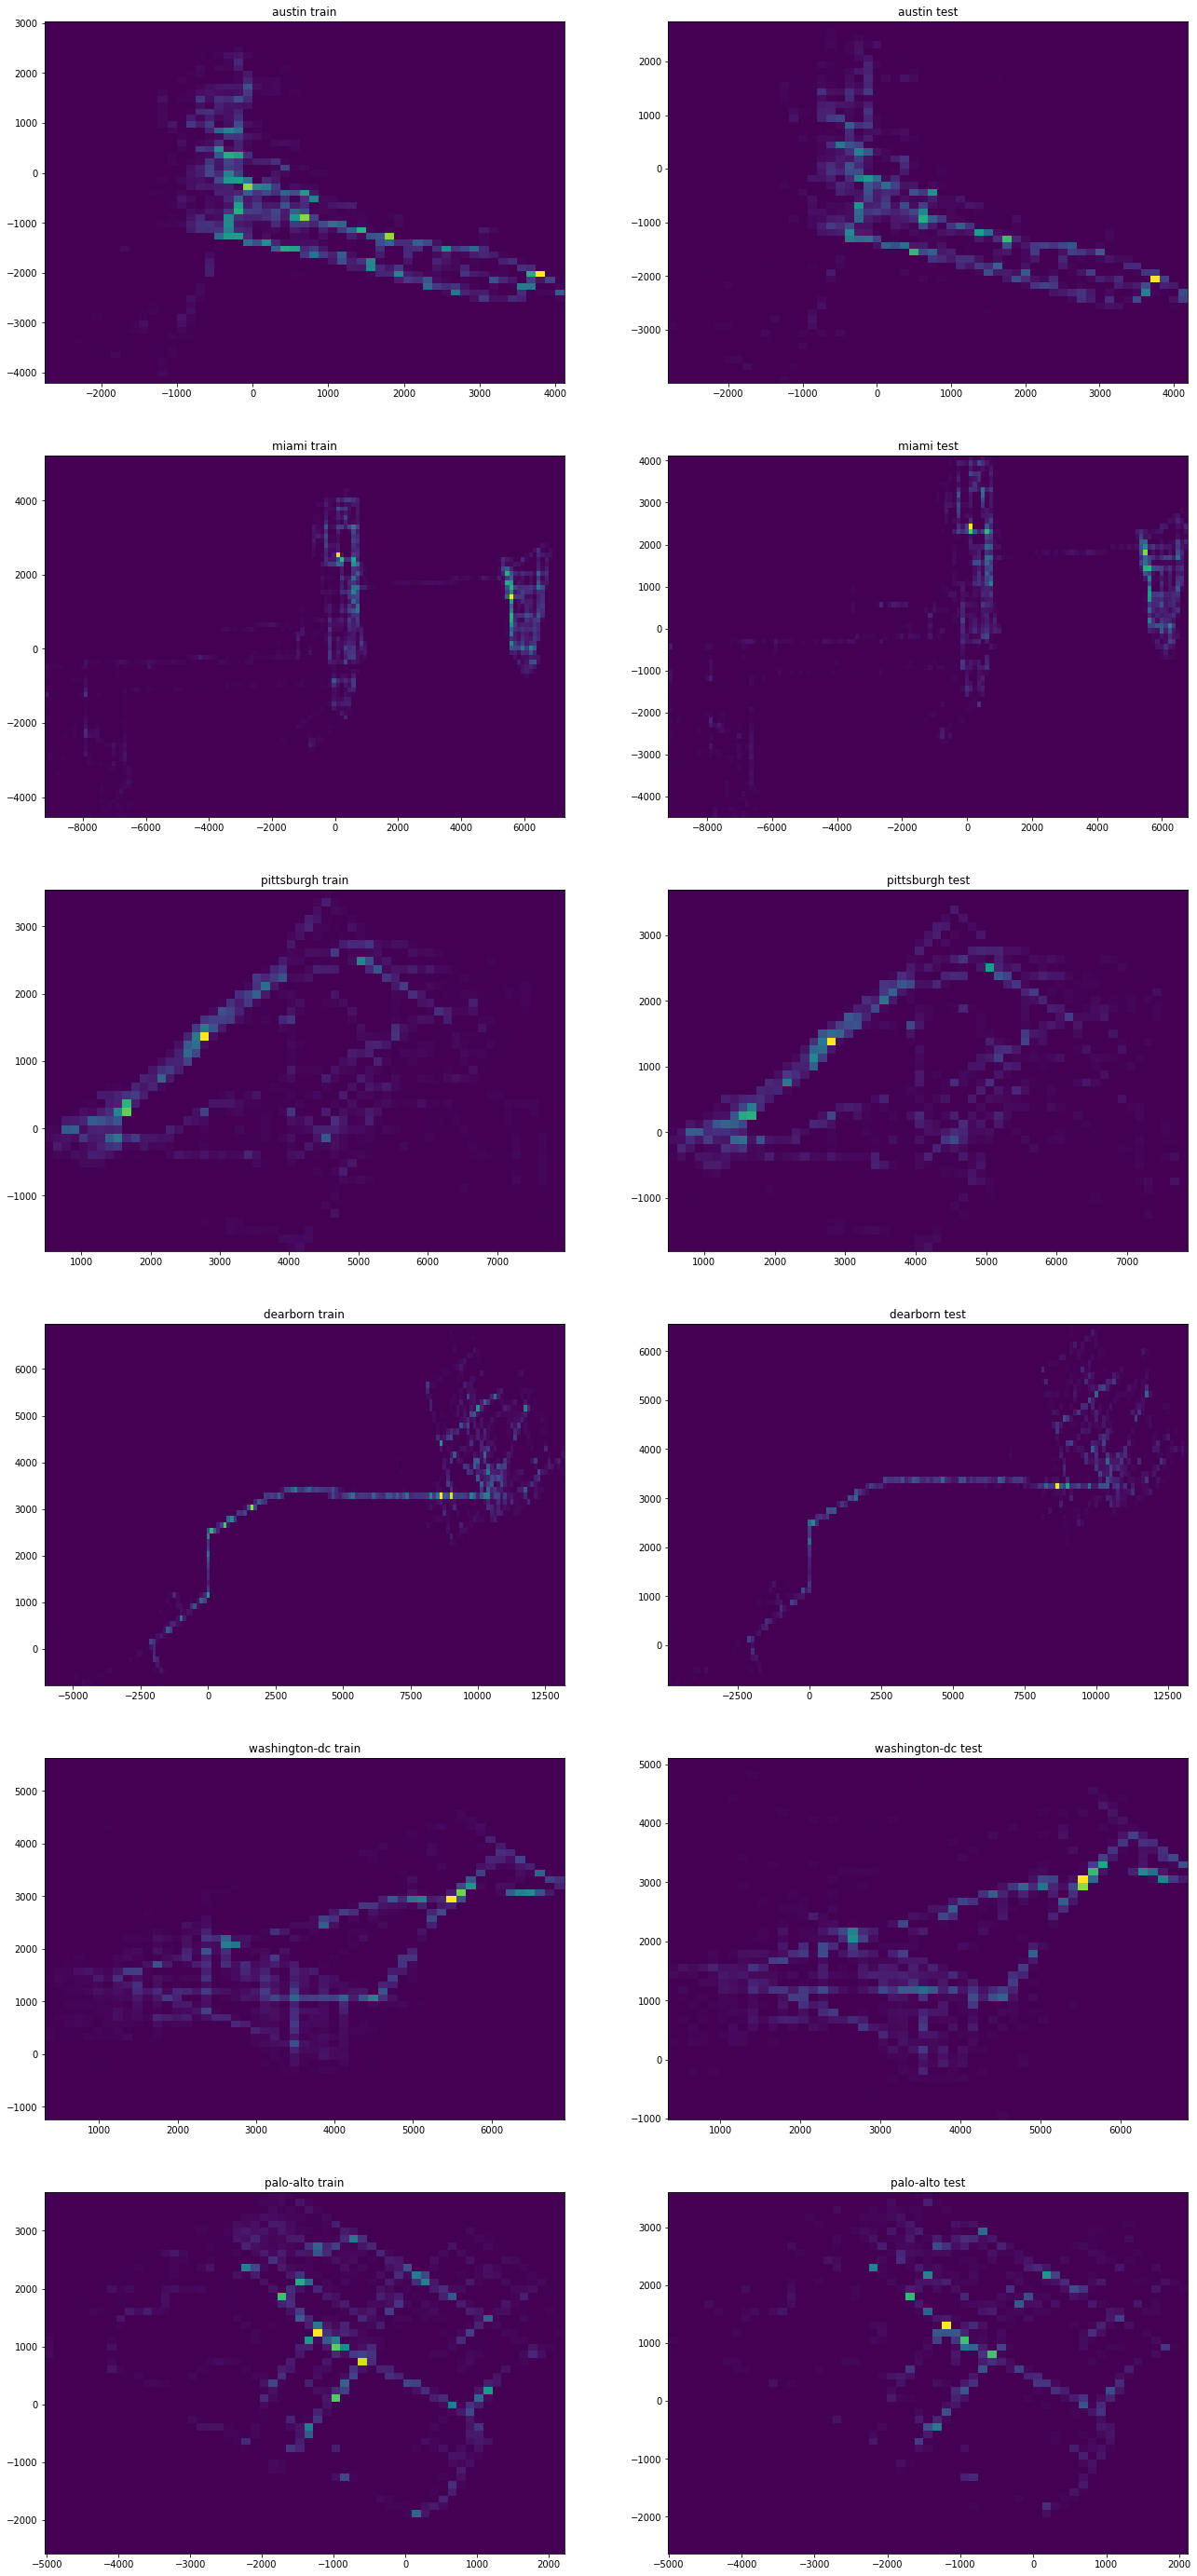

In [195]:
# brighter color means that more data lies at those coordinates
fig, ax = plt.subplots(6, 2, figsize=(22,50))
for row, city in enumerate(cities):
    for col, split in enumerate(splits):
        dataset = ArgoverseDataset(city = city, split = split)
        reshaped = dataset.inputs.reshape(
            dataset.inputs.shape[0]*dataset.inputs.shape[1], 2
        )
        
        x_min = min([i[0] for i in reshaped])
        x_max = max([i[0] for i in reshaped])
        y_min = min([i[1] for i in reshaped])
        y_max = max([i[1] for i in reshaped])
        
        ax[row,col].hist2d([i[0] for i in reshaped], [i[1] for i in reshaped],
                   bins=[np.arange(x_min, x_max, 125), np.arange(y_min, y_max, 125)]);
        ax[row,col].set_title(city + ' ' + split)

## Heatmap for input/output positions

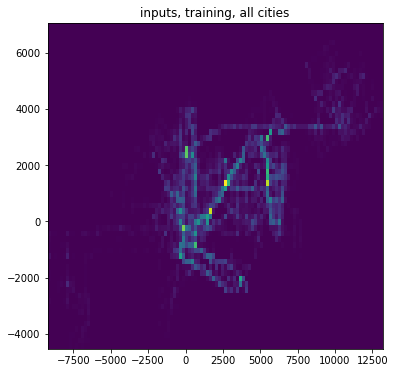

In [201]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
dataset = ArgoverseDataset(city = cities[0], split = 'train')
reshaped = dataset.inputs.reshape(
    dataset.inputs.shape[0]*dataset.inputs.shape[1], 2
)

for city in cities[1:]:
    dataset_next = ArgoverseDataset(city = city, split = 'train')
    reshaped_next = dataset_next.inputs.reshape(
        dataset_next.inputs.shape[0]*dataset_next.inputs.shape[1], 2
    )
    reshaped = np.append(reshaped, reshaped_next, axis=0)

x_min = min([i[0] for i in reshaped])
x_max = max([i[0] for i in reshaped])
y_min = min([i[1] for i in reshaped])
y_max = max([i[1] for i in reshaped])

ax.hist2d([i[0] for i in reshaped], [i[1] for i in reshaped],
           bins=[np.arange(x_min, x_max, 200), np.arange(y_min, y_max, 200)]);
ax.set_title('inputs, training, all cities');

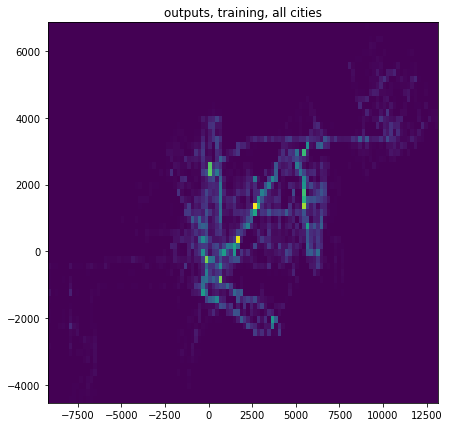

In [200]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))

dataset = ArgoverseDataset(city = cities[0], split = 'train')
reshaped = dataset.outputs.reshape(
    dataset.outputs.shape[0]*dataset.outputs.shape[1], 2
)

for city in cities[1:]:
    dataset_next = ArgoverseDataset(city = city, split = 'train')
    reshaped_next = dataset_next.outputs.reshape(
        dataset_next.outputs.shape[0]*dataset_next.outputs.shape[1], 2
    )
    reshaped = np.append(reshaped, reshaped_next, axis=0)

x_min = min([i[0] for i in reshaped])
x_max = max([i[0] for i in reshaped])
y_min = min([i[1] for i in reshaped])
y_max = max([i[1] for i in reshaped])

ax.hist2d([i[0] for i in reshaped], [i[1] for i in reshaped],
           bins=[np.arange(x_min, x_max, 200), np.arange(y_min, y_max, 200)]);
ax.set_title('outputs, training, all cities');

## Are inputs geospatially related?

In [1077]:
city = 'dearborn'
split = 'train'
train_dataset = ArgoverseDataset(city = city, split = split)

In [1078]:
def find_closest_point(train_dataset, train_averages, point):
    point = train_averages[point]
    dist = np.sqrt(np.sum(np.square(point - train_averages), axis=1))
    return np.argsort(dist)

In [1079]:
def find_overlaps(candidates, point):
    pass

In [1080]:
def visualize_points(train_dataset, points):
    inputs = []
    outputs = []
    for point in points:
        inputs.append(train_dataset.inputs[point])
        outputs.append(train_dataset.outputs[point])
        
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    
    for i, (inp, out) in enumerate(zip(inputs, outputs)):
        if i==0:
            inpx = inp[:,0]
            inpy = inp[:,1]
            outx = out[:,0]
            outy = out[:,1]
            ax.plot(inpx, inpy, alpha=0.45, c='green', linewidth=25)
            ax.plot(outx, outy, alpha=0.45, c='red',  linewidth=25)
        inpx = inp[:,0]
        inpy = inp[:,1]
        outx = out[:,0]
        outy = out[:,1]
        ax.scatter(inpx, inpy, c='b')
        ax.scatter(outx, outy, c='orange')
    
    ax.legend(['input','output','input others','output others'])

In [1083]:
train_averages = [i.mean(axis=0) for i in train_dataset.inputs]
closest_points = np.array([find_closest_point(train_dataset, train_averages, i) \
                  for i in range(len(train_dataset))])

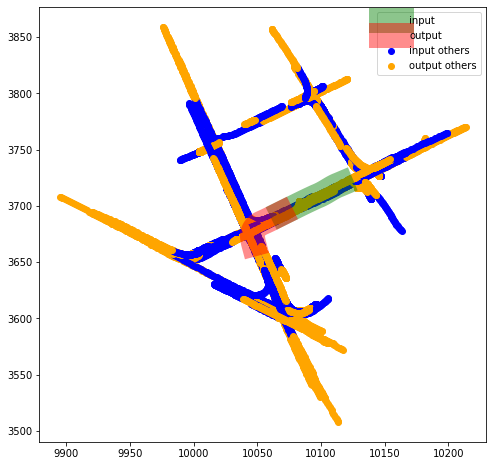

In [754]:
visualize_points(train_dataset, closest_points[3,0:150])